In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from itertools import combinations
from pytorchtools import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping

Using backend: pytorch


In [2]:
LABELS = 3
MAX_LENGTH =  60#36 
PIXEL = 49
BATCH_SIZE = 16
EMBED_SIZE = 300
DEVICE = 'cuda:0'
WINDOWS = 2
NB_EPOCH = 100
glove_file = '/root/liaowenxiong/pyworkspace/multi_analysis/dataset/glove/tmp_glove.6B.300d.txt'
tokenizer = BertWordPieceTokenizer("/root/liaowenxiong/pyworkspace/dataset/bert-base-uncased-vocab.txt", lowercase=True)


## build graph

In [3]:

def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,pixel):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)
    
        # text with pixel
        for j in range(max_len,max_len + pixel):
            for i in range(0,max_len):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    


batch_graph = get_batch_graph(BATCH_SIZE, MAX_LENGTH, WINDOWS)
batch_fusion_graph = get_fusion_batch(BATCH_SIZE, MAX_LENGTH, PIXEL)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


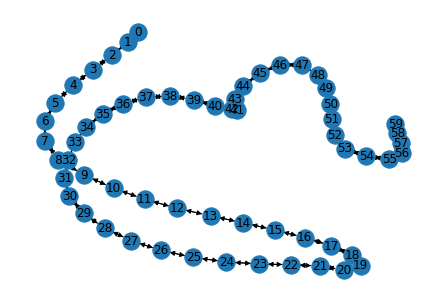

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


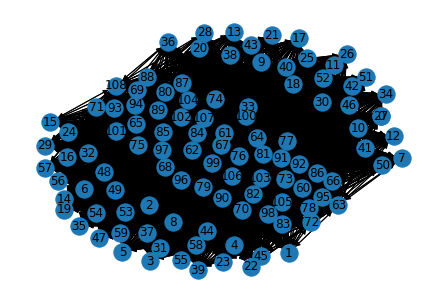

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


#### 数据读取

In [6]:
def read_text(path):
    with open(path,mode='r',encoding='gbk') as f:
        text = f.read()
        text = text.strip().lower().replace('#',' # ')
    return str(text)



def read_img(path,tfms):
    img = tfms(Image.open(path)).unsqueeze(0)
    return img


def load_data():
    
    # Preprocess image
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

    texts = []
    images = torch.Tensor()
    y = []
    index_ID_dict = {}
    all_data = pd.read_csv('./dataset/MVSA_Single/labelResultAll.csv')
    for index,row in all_data.iterrows():
        ID = row['ID']
        index_ID_dict[index] = ID
        if ID%100 == 0:
            print(ID)
        label = row['label']
        y.append(label)
        text_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.txt')
        texts.append(read_text(text_path))
    #     image_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.jpg')
    #     image = read_img(image_path,tfms)
    #     if images.shape[0] ==0:
    #         images = image
    #     else:
    #         images = torch.cat([images, image], 0)



    label_dict = {'negative' : 0, 'neutral' : 1, 'positive' : 2 }
    y = [label_dict[l] for l in y]
    y = np.array(y)

    # torch.save(images,'./dataset/single_images.pkl')
    # torch.save(y,'./dataset/single_y.pkl')

    images = torch.load('./dataset/single_images.pkl')
    
    return texts,images,y



def get_idx2word(texts):
    cutoff = 1
    word_to_idx = {}
    word_to_idx['<unk>'] = 0
    word_freq = {}
    for text in texts:
        for t in text:
            if t in word_freq:
                word_freq[t] = word_freq[t] + 1
            else:
                word_freq[t] = 1

    for word, freq in word_freq.items():
        if freq > cutoff:
            word_to_idx[word] = len(word_to_idx) 

    idx_to_word = {i: word for  (word,i) in word_to_idx.items()}
    
    return word_to_idx,idx_to_word

def get_token(text,word_to_idx,max_length,pad=0):
    idx = []
    text = text[0:max_length]
    for t in text:
        if t in word_to_idx:
            idx.append(word_to_idx[t])
        else:
            idx.append(pad)
    idx = idx if len(idx) == max_length else np.concatenate((idx,np.zeros(max_length-len(idx))))
    
    return idx

def get_token_text(texts):
    x_texts = []
    for t in texts:
        x_texts.append(get_token(t,word_to_idx,max_length = MAX_LENGTH,pad=0))
    x_texts = np.array(x_texts)
    
    return x_texts


def load_glove_weight(glove_file,idx_to_word,embed_size):
    # # #加载词向量
    
    wvmodel = KeyedVectors.load_word2vec_format(glove_file, binary=False,encoding='utf8')
    wvmodel.init_sims(replace=True)  

    weight = torch.zeros(len(idx_to_word), embed_size)

    for i in range(len(wvmodel.index2word)):
        try:
            index = word_to_idx[wvmodel.index2word[i]]
        except:
            continue

        weight[index, :] = torch.from_numpy(wvmodel.get_vector(
                idx_to_word[word_to_idx[wvmodel.index2word[i]]]))
    return weight

def get_data_loader(shuffle_index,fold_index,fold_N = 10):
    fold_sample_num = len(shuffle_index)//fold_N
    test_index = shuffle_index[fold_sample_num * fold_index : fold_sample_num * (fold_index+1)]
    train_val_index = np.concatenate((shuffle_index[0:fold_sample_num * fold_index],shuffle_index[fold_sample_num * (fold_index+1):])).astype(int)
    train_index = train_val_index[0: -fold_sample_num]
    val_index = train_val_index[-fold_sample_num:]
    
    print('test_index:{begin}==>{end}'.format(begin = fold_sample_num * fold_index,end =  fold_sample_num * (fold_index+1)))

    train_texts = x_texts[train_index]
    train_images = images[train_index]
    train_y = y[train_index]
    
    val_texts = x_texts[val_index]
    val_images = images[val_index]
    val_y = y[val_index]
    
    test_texts = x_texts[test_index]
    test_images = images[test_index]
    test_y = y[test_index]

    train_set = data.TensorDataset(torch.LongTensor(train_texts),torch.FloatTensor(train_images) ,torch.LongTensor(train_y))
    val_set = data.TensorDataset(torch.LongTensor(val_texts),torch.FloatTensor(val_images), torch.LongTensor(val_y))
    test_set = data.TensorDataset(torch.LongTensor(test_texts),torch.FloatTensor(test_images), torch.LongTensor(test_y))

    train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                             shuffle=True)
    val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    test_data_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    
    return train_data_loader,val_data_loader,test_data_loader



texts,images,y = load_data()
texts = [tokenizer.encode(t).tokens[1:-1] for t  in texts]
word_to_idx,idx_to_word = get_idx2word(texts)
x_texts = get_token_text(texts)
glove_weight = load_glove_weight(glove_file,idx_to_word,EMBED_SIZE)


100
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1700
1800
1900
2000
2100
2500
2600
2700
2800
2900
3100
3200
3300
3400
3500
3600
3700
3800
4000
4100
4200
4300
4500
4600
4700
4800
5000
5100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


In [7]:
class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
       
        h = self.linear(node.data['h'])
        h = self.activation(h)
        
        return {'h1' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)
        self.msg = fn.copy_src(src='h', out='m')
    
    def reduce(self,nodes):
        """Take an average over all neighbor node features hu and use it to
        overwrite the original node feature."""
        accum = torch.mean(nodes.mailbox['m'], 1)
        h = nodes.data['h']
        accum = 0.8 * accum + 0.2 * h

        return {'h': accum}

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature

        g.update_all(self.msg, self.reduce)
        g.apply_nodes(func=self.apply_mod)
      
        return g.ndata.pop('h1')


class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
#         # equation (4)
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):

        # equation (1)
        h = self.fc(h)
        bg.ndata['h'] = h
        # equation (2)
        bg.apply_edges(self.edge_attention)
        # equation (3) & (4)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
#         print('weight',weights)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, embed_size, labels,max_length,pixel,drop_rate = 0.4,glove_weight=None):
        super(Classifier, self).__init__()
        self.labels = labels
        self.embedding = nn.Embedding.from_pretrained(glove_weight,freeze= False)
        self.dropout = nn.Dropout(drop_rate)
        self.text_normal = nn.LayerNorm((max_length,embed_size))
        self.image_normal = nn.LayerNorm((pixel,embed_size))
        self.embed_size = embed_size
        self.GCN = GCN(embed_size, self.embed_size, F.relu)
        self.GCN2 = GCN(self.embed_size, self.embed_size, F.relu)
        self.GAT = GAT(self.embed_size, self.embed_size, F.relu)
        self.att = SelfAttention(self.embed_size )
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.embed_size)

        self.classify_h = nn.Linear(self.embed_size  , self.embed_size)
        self.classify = nn.Linear(self.embed_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)
        
        text = self.embedding(text)
        text = torch.reshape(text,(-1,self.embed_size))   #[-1,hidden_size]
        text = self.GCN(bg, text)
        text = torch.reshape(text,(bs,-1,self.embed_size))   #[bs,max_len,hidden_size]
        text = self.text_normal(text)
        with torch.no_grad():
            img = self.image_model.extract_features(image) #[bs,1280,7,7]  1536
#         img =  F.tanh(img)
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.embed_size))   #[bs,49,hidden_size]
#         img = self.image_normal(img)

        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)

        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)

#         feature = torch.cat([feature_short, gat_feature,head_feature], 1)
#         feature = torch.reshape(feature,(bs,-1))
        feature = self.dropout(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)

    
def model_test(data_loader,model,report = False):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []
    loss_l = []
    loss_func = nn.CrossEntropyLoss()
    for step,(b_texts,b_image_features, test_y_batch) in enumerate(data_loader):

        
        b_texts = b_texts.to(torch.device(DEVICE))
        b_image_features = b_image_features.to(torch.device(DEVICE))
        test_y_batch = test_y_batch.to(torch.device(DEVICE))
        
        test_net_out = model(b_texts,b_image_features)
        loss = loss_func(test_net_out, test_y_batch) 
        loss_l.append(loss.cpu().data.numpy())
        
        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch.cpu().data.numpy()), axis=0)
    
    if report:
        print(classification_report(test_Y,pred_Y,digits = 5))
    f1_macro = f1_score(test_Y,pred_Y,average='macro')
    f1_weighted = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    loss_mean = np.mean(np.array(loss_l))
    
    return f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean


def draw_cofusion_matrix(test_Y,pred_Y, labels=[0, 1, 2]):
    sns.set()
    
    plt.figure(figsize=(300, 300))
    f,ax=plt.subplots()
    C2= confusion_matrix(test_Y,pred_Y, labels=[0, 1, 2],normalize = 'true')
    print(C2) #打印出来看看
    sns.heatmap(C2,annot=True,ax=ax,cmap="YlGnBu") #画热力图

    labels = ['negative','neutral','positive']
    ax.set_title('confusion matrix') #标题
    ax.set_xticklabels( labels) 
    ax.set_yticklabels(labels) 
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    plt.show()

test_index:0==>451
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.12
epoch:0, step:100, loss:1.10
epoch:0, step:200, loss:0.70
*** 0.25366300366300365 0.46739236373382714 0.614190687361419
0.43392684551221133, best: 0.43392684551221133
epoch:1, step:0, loss:0.85
epoch:1, step:100, loss:0.90
epoch:1, step:200, loss:1.27
*** 0.488419017288444 0.666249896600215 0.7073170731707317
0.5978680452295878, best: 0.5978680452295878
epoch:2, step:0, loss:1.01
epoch:2, step:100, loss:0.49
epoch:2, step:200, loss:0.83
*** 0.528231133750448 0.6577269537061747 0.6962305986696231
0.6122308662100355, best: 0.6122308662100355
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.61
epoch:3, step:100, loss:0.30
epoch:3, step:200, loss:0.62
*** 0.5821198802885021 0.6751543040496106 0.6829268292682927
0.6325233547783975, best: 0.6325233547783975
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.33
epoch:4, step:100, loss:0.35
epoch:4, step:200, loss:0.14
*** 0.584869372755

<Figure size 21600x21600 with 0 Axes>

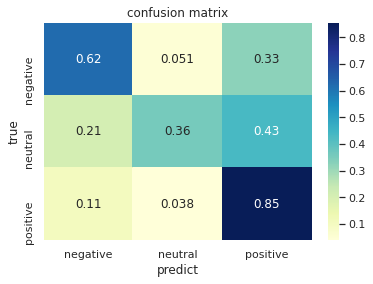

test_index:451==>902
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.15
epoch:0, step:100, loss:0.92
epoch:0, step:200, loss:1.02
*** 0.25366300366300365 0.46739236373382714 0.614190687361419
0.43392684551221133, best: 0.43392684551221133
epoch:1, step:0, loss:1.07
epoch:1, step:100, loss:0.69
epoch:1, step:200, loss:0.95
*** 0.459587022510223 0.6545668220340135 0.70509977827051
0.5823434003903665, best: 0.5823434003903665
epoch:2, step:0, loss:0.63
epoch:2, step:100, loss:0.34
epoch:2, step:200, loss:0.48
*** 0.5070344153054945 0.6765439787427575 0.6984478935698448
0.6027411544376697, best: 0.6027411544376697
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.48
epoch:3, step:100, loss:0.37
epoch:3, step:200, loss:0.23
*** 0.5677987811455075 0.6948442213410867 0.7095343680709535
0.6386665746082305, best: 0.6386665746082305
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.44
epoch:4, step:100, loss:0.16
epoch:4, step:200, loss:0.14
*** 0.5618812552

<Figure size 21600x21600 with 0 Axes>

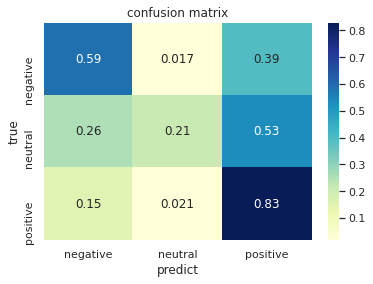

test_index:902==>1353
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.11
epoch:0, step:100, loss:0.77
epoch:0, step:200, loss:0.67
*** 0.29041134269218843 0.5022751006242242 0.6297117516629712
0.46006154717757985, best: 0.46006154717757985
epoch:1, step:0, loss:0.66
epoch:1, step:100, loss:0.93
epoch:1, step:200, loss:0.71
*** 0.5002084260404153 0.6818865690838307 0.7073170731707317
0.6037627496055735, best: 0.6037627496055735
epoch:2, step:0, loss:0.78
epoch:2, step:100, loss:0.51
epoch:2, step:200, loss:0.64
*** 0.5672425203450367 0.713245206585735 0.7339246119733924
0.6505835661592145, best: 0.6505835661592145
epoch:3, step:0, loss:0.42
epoch:3, step:100, loss:0.65
epoch:3, step:200, loss:0.22
*** 0.5983022959500918 0.692678436261153 0.6940133037694013
0.6461577998597465, best: 0.6505835661592145
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.35
epoch:4, step:100, loss:0.09
epoch:4, step:200, loss:0.09
*** 0.5742795698924731 0.6896960160217438 0.7050

<Figure size 21600x21600 with 0 Axes>

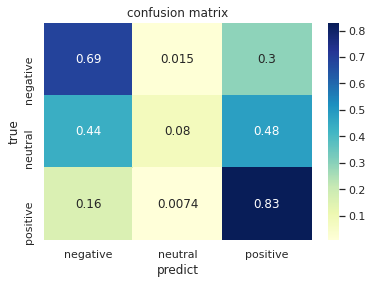

test_index:1353==>1804
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10
epoch:0, step:100, loss:1.04
epoch:0, step:200, loss:0.81
*** 0.2742482454792275 0.4860070529537182 0.6208425720620843
0.44754540877065585, best: 0.44754540877065585
epoch:1, step:0, loss:0.84
epoch:1, step:100, loss:0.82
epoch:1, step:200, loss:0.71
*** 0.45704805591150227 0.6575601388791606 0.6917960088691796
0.574422032390341, best: 0.574422032390341
epoch:2, step:0, loss:0.59
epoch:2, step:100, loss:0.70
epoch:2, step:200, loss:0.58
*** 0.5894313449335937 0.7033882615233402 0.7139689578713969
0.6517001514024954, best: 0.6517001514024954
epoch:3, step:0, loss:0.37
epoch:3, step:100, loss:0.33
epoch:3, step:200, loss:0.54
*** 0.5730313448606384 0.6756874801113284 0.6851441241685144
0.6290877345145764, best: 0.6517001514024954
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.25
epoch:4, step:100, loss:0.19
epoch:4, step:200, loss:0.09
*** 0.5451439172369404 0.6623212924971291 0.680

<Figure size 21600x21600 with 0 Axes>

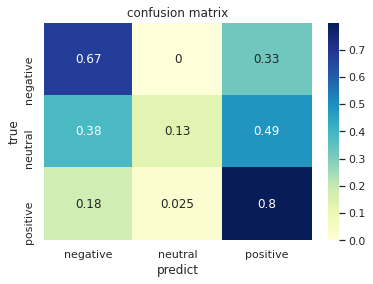

test_index:1804==>2255
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10
epoch:0, step:100, loss:0.94
epoch:0, step:200, loss:0.83
*** 0.27896458910757344 0.49056326824844393 0.6208425720620843
0.4499035805848288, best: 0.4499035805848288
epoch:1, step:0, loss:0.76
epoch:1, step:100, loss:0.73
epoch:1, step:200, loss:0.69
*** 0.4153006137069262 0.6084899482322927 0.6762749445676275
0.5457877791372768, best: 0.5457877791372768
epoch:2, step:0, loss:0.50
epoch:2, step:200, loss:0.69
*** 0.5923960363199138 0.6877148036036029 0.6851441241685144
0.6387700802442141, best: 0.6387700802442141
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.37
epoch:3, step:100, loss:0.52
epoch:3, step:200, loss:0.53
*** 0.5698504778646623 0.6696087026237519 0.6895787139689579
0.62971459591681, best: 0.6387700802442141
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.21
epoch:4, step:100, loss:0.12
epoch:4, step:200, loss:0.12
*** 0.5539020791415158 0.6587812462357292 0

<Figure size 21600x21600 with 0 Axes>

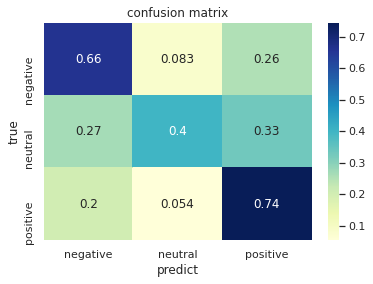

test_index:2255==>2706
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.17
epoch:0, step:100, loss:0.71
epoch:0, step:200, loss:0.82
*** 0.25366300366300365 0.46739236373382714 0.614190687361419
0.43392684551221133, best: 0.43392684551221133
epoch:1, step:0, loss:0.89
epoch:1, step:100, loss:0.79
epoch:1, step:200, loss:0.76
*** 0.4380154356245776 0.6147953764060444 0.6740576496674058
0.5560365426459917, best: 0.5560365426459917
epoch:2, step:0, loss:0.82
epoch:2, step:100, loss:0.57
epoch:2, step:200, loss:0.43
*** 0.5613825959945496 0.685743559545261 0.6984478935698448
0.6299152447821972, best: 0.6299152447821972
epoch:3, step:0, loss:0.43
epoch:3, step:100, loss:0.43
epoch:3, step:200, loss:0.40
*** 0.5176689678391101 0.658621296955329 0.6917960088691796
0.6047324883541448, best: 0.6299152447821972
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.23
epoch:4, step:100, loss:0.24
epoch:4, step:200, loss:0.04
*** 0.5270491819787595 0.653993690407294 0.6629

<Figure size 21600x21600 with 0 Axes>

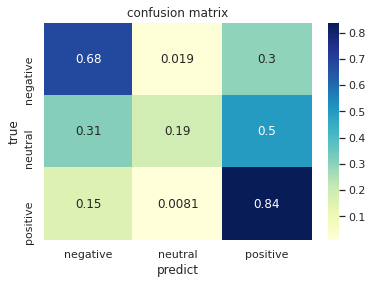

test_index:2706==>3157
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.06
epoch:0, step:100, loss:1.22
epoch:0, step:200, loss:0.71
*** 0.25366300366300365 0.46739236373382714 0.614190687361419
0.43392684551221133, best: 0.43392684551221133
epoch:1, step:0, loss:0.64
epoch:1, step:100, loss:0.72
epoch:1, step:200, loss:0.66
*** 0.45885047281323876 0.6582215840291866 0.6917960088691796
0.5753232408412092, best: 0.5753232408412092
epoch:2, step:0, loss:0.55
epoch:2, step:100, loss:0.46
epoch:2, step:200, loss:0.43
*** 0.5549412390206189 0.6949180805472273 0.7184035476718403
0.6366723933462296, best: 0.6366723933462296
epoch:3, step:0, loss:0.35
epoch:3, step:100, loss:0.35
epoch:3, step:200, loss:0.39
*** 0.546974319857615 0.6826443820918342 0.6984478935698448
0.6227111067137299, best: 0.6366723933462296
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.15
epoch:4, step:100, loss:0.09
epoch:4, step:200, loss:0.13
*** 0.5435790298406677 0.6688412686697294 0.6

<Figure size 21600x21600 with 0 Axes>

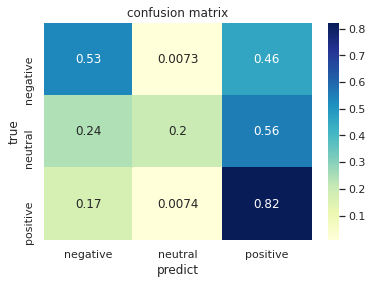

test_index:3157==>3608
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.16
epoch:0, step:100, loss:0.81
epoch:0, step:200, loss:0.75
*** 0.2831340198027637 0.4939550602177922 0.6208425720620843
0.45198829593242396, best: 0.45198829593242396
epoch:1, step:0, loss:0.80
epoch:1, step:100, loss:0.75
epoch:1, step:200, loss:0.74
*** 0.4788960388960389 0.6530290949803145 0.6940133037694013
0.5864546713327201, best: 0.5864546713327201
epoch:2, step:0, loss:0.63
epoch:2, step:100, loss:1.05
epoch:2, step:200, loss:0.54
*** 0.5525672180220038 0.6775257408020431 0.70509977827051
0.6288334981462569, best: 0.6288334981462569
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.73
epoch:3, step:100, loss:0.29
epoch:3, step:200, loss:0.53
*** 0.5777849042566935 0.6746182646866499 0.6718403547671841
0.6248126295119387, best: 0.6288334981462569
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.22
epoch:4, step:100, loss:0.35
epoch:4, step:200, loss:0.10
*** 0.58205760

<Figure size 21600x21600 with 0 Axes>

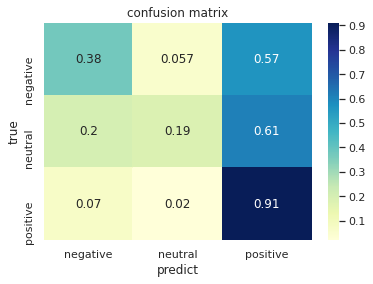

test_index:3608==>4059
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.13
epoch:0, step:100, loss:0.91
epoch:0, step:200, loss:0.87
*** 0.25366300366300365 0.46739236373382714 0.614190687361419
0.43392684551221133, best: 0.43392684551221133
epoch:1, step:0, loss:0.84
epoch:1, step:100, loss:0.99
epoch:1, step:200, loss:0.73
*** 0.4657287703104245 0.6487481743595117 0.6962305986696231
0.5809796844900238, best: 0.5809796844900238
epoch:2, step:0, loss:0.63
epoch:2, step:100, loss:0.46
epoch:2, step:200, loss:0.37
*** 0.6105674450163517 0.714547536632625 0.7228381374722838
0.6667027912443177, best: 0.6667027912443177
epoch:3, step:0, loss:0.58
epoch:3, step:100, loss:0.61
epoch:3, step:200, loss:0.21
*** 0.5830783595489478 0.6816759519772432 0.6807095343680709
0.6318939469585094, best: 0.6667027912443177
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.28
epoch:4, step:100, loss:0.18
epoch:4, step:200, loss:0.26
*** 0.5624354745382024 0.685919211117504 0.696

<Figure size 21600x21600 with 0 Axes>

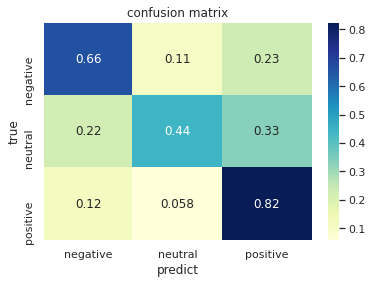

test_index:4059==>4510
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.15
epoch:0, step:100, loss:0.72
epoch:0, step:200, loss:0.94
*** 0.2542295381801555 0.47012734998281525 0.6164079822616408
0.43531876022089816, best: 0.43531876022089816
epoch:1, step:0, loss:0.94
epoch:1, step:100, loss:0.68
epoch:1, step:200, loss:0.64
*** 0.5007622075487079 0.6811186954996343 0.7073170731707317
0.6040396403597198, best: 0.6040396403597198
epoch:2, step:0, loss:0.80
epoch:2, step:100, loss:0.25
epoch:2, step:200, loss:0.59
*** 0.49523545174512273 0.6557231718487674 0.6917960088691796
0.5935157303071512, best: 0.6040396403597198
epoch:3, step:0, loss:0.74
epoch:3, step:100, loss:0.56
epoch:3, step:200, loss:0.15
*** 0.5969899645190592 0.7040939804463168 0.720620842572062
0.6588054035455606, best: 0.6588054035455606
EarlyStopping counter: 1 out of 3
epoch:4, step:0, loss:0.31
epoch:4, step:100, loss:0.35
epoch:4, step:200, loss:0.07
*** 0.5602611326295537 0.6877442295519085 0.7

<Figure size 21600x21600 with 0 Axes>

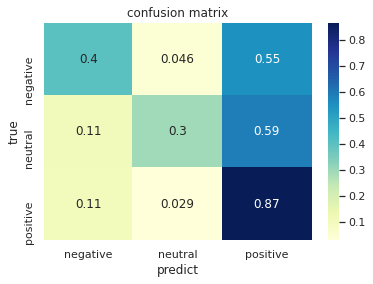

[0.6294104716149403, 0.5591385273192145, 0.5237641411844968, 0.5360926564544778, 0.5990771194899519, 0.5843881171027417, 0.5424372784793002, 0.5030543204492521, 0.6372073799638821, 0.54406911007228]
[0.7156786544221669, 0.6864451662700997, 0.678922281097934, 0.6916631872948282, 0.6849718055837877, 0.6955932162453141, 0.6537256460014041, 0.6191009057814819, 0.7404352317934487, 0.6541616175277412]
[0.7250554323725056, 0.7006651884700665, 0.70509977827051, 0.70509977827051, 0.6829268292682927, 0.7139689578713969, 0.6718403547671841, 0.656319290465632, 0.738359201773836, 0.6762749445676275]
max macro_f1:0.6372073799638821, max weight_f1:0.7404352317934487,max acc:0.738359201773836
min macro_f1:0.5030543204492521, min weight_f1:0.6191009057814819,min acc:0.656319290465632
mean macro_f1:0.5658639122130537, mean weight_f1:0.6820697712018207,mean acc:0.697560975609756
mean run time: 62.02925350666046


In [8]:
shuffle_index = list(range(len(y)))
random.Random(1337).shuffle(shuffle_index) 
f1_macro_list = []
f1_weighted_list = []
acc_list = []
time_list = []
import time
for fold in range(10):
    
    
    train_data_loader,val_data_loader,test_data_loader = get_data_loader(shuffle_index,fold)
    
    early_stopping = EarlyStopping( delta=1e-4, patience=3)
    
    #构造模型 
    net = Classifier(embed_size = EMBED_SIZE,labels=LABELS,max_length = MAX_LENGTH,pixel = PIXEL,glove_weight=glove_weight)
    net.to(torch.device(DEVICE))
    optimizer = torch.optim.Adam(params = net.parameters(),
                                 lr = 1e-4)
    loss_func = nn.CrossEntropyLoss()
    begin = time.time()
    max_acc = 0
    # training and testing
    for epoch in range(NB_EPOCH):
        net.train()
        for step, (b_texts,b_image_features, b_y) in enumerate(train_data_loader):        # gives batch data
            b_texts = b_texts.to(torch.device(DEVICE))
            b_image_features = b_image_features.to(torch.device(DEVICE))
            b_y = b_y.to(torch.device(DEVICE))
            out = net(b_texts,b_image_features)                               # rnn output
            loss = loss_func(out, b_y) 
            if step %100 ==0:
                print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
            optimizer.zero_grad()                           # clear gradients for this training step
            loss.backward()                                 # backpropagation, compute gradients
            optimizer.step()                                # apply gradients
        net.eval()
        #每训练一轮，使用验证集验证
        f1_macro,f1_weighted,acc,test_Y,pred_Y,val_loss = model_test(val_data_loader,net)
        print('***',f1_macro,f1_weighted,acc)
        acc = (f1_macro+acc)/2
        if acc >max_acc:
            max_acc = acc
            torch.save(net, 'best_dgl_single.pkl')
        print('{acc}, best: {max_acc}'.format(acc = acc,max_acc = max_acc))
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    print('run time:',time.time()-begin)
    time_list.append(time.time()-begin)
    net = torch.load('best_dgl_single.pkl')
    net.eval()
    f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean = model_test(test_data_loader, net,report = True)
    print('----***----',f1_macro,f1_weighted,acc)
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    acc_list.append(acc)
    draw_cofusion_matrix(test_Y,pred_Y)
print(f1_macro_list)
print(f1_weighted_list)
print(acc_list)
print('max macro_f1:{macro_f1}, max weight_f1:{weight_f1},max acc:{acc}'.format(
    macro_f1 = max(f1_macro_list),weight_f1 = max(f1_weighted_list),acc = max(acc_list)))
print('min macro_f1:{macro_f1}, min weight_f1:{weight_f1},min acc:{acc}'.format(
    macro_f1 = min(f1_macro_list),weight_f1 = min(f1_weighted_list),acc = min(acc_list)))
print('mean macro_f1:{macro_f1}, mean weight_f1:{weight_f1},mean acc:{acc}'.format(
    macro_f1 = np.mean(f1_macro_list),weight_f1 = np.mean(f1_weighted_list),acc = np.mean(acc_list)))
print('mean run time: {time}'.format(time = np.mean(time_list)))